In [ ]:
#!pip install --upgrade pip
#!pip install numpy
#!pip install pandas
#!pip install xlrd
#!pip install GEOS
#!pip install GeobricksProj4ToEPSG
#!conda install -c conda-forge cartopy --yes
#!pip install geopandas

In [1]:
import numpy as np
import pandas
from IPython.display import display, HTML
import geopandas as gpd
import matplotlib.pyplot as plt

pandas.set_option('display.max_colwidth', -1)

basedir = '/home/idies/workspace/persistent/censusdata/'

# category can be one of: demographics, ancestry, residence, transportation... 
#      household, income, employment, housing, qa

category = 'demographics'

vardir = basedir + 'variables/'
geodir = basedir + 'geography/'
datadir = basedir + 'data/'
errordir = basedir + 'error/'

print('Reading metadata...')
metadata_df = pandas.read_csv(vardir+'/variables_acs2016_{0:}.csv'.format(category), low_memory=False, index_col=0, encoding='utf-8')
metadata_df.index.name = ''
metadata_df = metadata_df.rename(columns={'variable.1': 'variable'})

geo_metadata_df = pandas.read_csv(geodir+'geo_variables_acs2016.csv', low_memory=False, index_col=0, encoding='utf-8')

print('Reading geography...')
geo_df = pandas.read_csv(geodir+'geo_acs2016.csv', low_memory=False, index_col=0, encoding='utf-8')
geo_df = geo_df.set_index('GEOID', drop=False)

print('Reading data (estimates)...')
data_df = pandas.read_csv(datadir+'data_acs2016_{0:}.csv'.format(category), low_memory=False, index_col=0, encoding='utf-8')

print('Reading margins of error...')
error_df = pandas.read_csv(errordir+'error_acs2016_{0:}.csv'.format(category), low_memory=False, index_col=0, encoding='utf-8')

print('Calculating geography sumary levels...')
data_df['SUMLEVEL'] = data_df['GEOID'].apply(lambda x: int(x[0:3]))

print('Documenting geography summary levels...')
sumlevel_df = pandas.read_csv(geodir+'geo_summary_levels.csv', encoding='utf-8')
sumlevel_df = sumlevel_df.set_index('SUMLEVEL', drop=False)

print('Documenting state codes')
geo_df[['STATE','STUSAB']].dropna().drop_duplicates().sort_values('STATE').to_csv(geodir+'statecodes.csv', encoding='utf-8', index=False)
statecodes_df = pandas.read_csv(geodir+'statecodes.csv', encoding='utf-8')
statecodes_df['STATE'] = statecodes_df['STATE'].astype('int')
statecodes_df = statecodes_df.set_index('STATE', drop=False)

print('\n')
print('Done!')
#sumlevel_df

Reading metadata...
Reading geography...
Reading data (estimates)...
Reading margins of error...
Calculating geography sumary levels...
Documenting geography summary levels...
Documenting state codes


Done!


In [2]:
def find_geography4(gdf, tofindlist, wantlevels = []):
    geosub_df = pandas.DataFrame()
    geolist = []

    if (len(tofindlist) == 0):
        print('CAUTION: No geography search phrases specified, returning every geography!')
    if (len(tofindlist) > 4):
        print('ERROR: list contains more than four geography search phrases, searching for only the first three')
    try:
        string1 = tofindlist[0]
    except IndexError:
        string1 = ''
    try:
        string2 = tofindlist[1]
    except IndexError:
        string2 = ''
    try:
        string3 = tofindlist[2]
    except IndexError:
        string3 = ''
    try:
        string4 = tofindlist[3]
    except IndexError:
        string4 = ''
    
    # If wantlevels not specified, search through every level
    if (len(wantlevels) == 0):
        geosub_df = gdf
    for thislevel in wantlevels: 
        if (not(np.isnan(thislevel))):
            geosub_df = pandas.concat((geosub_df,gdf[gdf['SUMLEVEL'] == thislevel]))
#            print(geosub_df.head(1))
    found_df = geosub_df[geosub_df['NAME'].apply(lambda x: (string1 in x) & (string2 in x) & (string3 in x) & (string4 in x))]
    geolist = found_df['GEOID'].values.tolist()

    return geolist
    
def warn_geo_level():
    
    helpshow_df = pandas.read_csv('/home/idies/workspace/raddick_acs_data/geography/geo_summary_levels.csv')
    helpshow_df = helpshow_df.set_index('SUMLEVEL')

    showme = '<table><tr><th>SUMLEVEL</th><th>Description</th><th>Count</th></tr>'
    for slvl, row in helpshow_df.iterrows():
        showme += '<tr><td>'+str(slvl)+'</td><td>'+str(row['description'])+'</td><td>'+str(row['acscount'])+'</td></tr>'
    showme += '</table>'

    return showme
    
def find_variables4(mdf, tofindlist):
    # NEED TO REWRITE TO USE REGEX INSTEAD, because now only "Male" returns men; "male" returns women b/c feMALE
    varlist = []
    if (len(tofindlist) == 0):
        print('CAUTION: No search phrases specified, returning every variable!')
    if (len(tofindlist) > 4):
        print('ERROR: list contains more than four search phrases, searching for only the first three')
    try:
        string1 = tofindlist[0]
    except IndexError:
        string1 = ''
    try:
        string2 = tofindlist[1]
    except IndexError:
        string2 = ''
    try:
        string3 = tofindlist[2]
    except IndexError:
        string3 = ''
    try:
        string4 = tofindlist[3]
    except IndexError:
        string4 = ''
            
    varlist = mdf['variable'][mdf['description'].apply(lambda x: (string1 in x) & (string2 in x) & (string3 in x) & (string4 in x))].values.tolist()
    return varlist

def get_data(df, varlist = [], geolist = []):

    rdf = pandas.DataFrame()
    
    if (len(geolist) == 0):
        print('Caution: No geographies specified, will return all geographies')
        rdf = df
    else:
        for thisgeo in geolist:
            try:
                rdf = rdf.append(df.loc[thisgeo])
            except:
                print('Geography {0:} not found. Skipping.'.format(thisgeo))

    if (len(varlist) == 0):
        print('CAUTION: No variables specified, will return all variables')
    else:
        vars_that_exist = ['GEOID']
        for thisvar in varlist:
            if (thisvar in df.columns):
                vars_that_exist.append(thisvar)
            else:
                print('Variable {0:} not found. Skipping.'.format(thisvar))
        rdf = rdf[vars_that_exist]
    rdf.index.name = ''

    return rdf
    
print('Done')

Done


In [3]:
phrases = []
phrases.append('Total Population')
phrases.append('one race')
phrases.append('White alone')
thelist = find_variables4(metadata_df, phrases)
for x in thelist:
    print(x, metadata_df['description'].loc[x])
print('\n')

#B01001_001 SEX BY AGE for Total Population% Total:
#B02001_002 RACE for Total Population% Black or African American alone
#B02003_003 DETAILED RACE for Total Population% Population of one race:% White alone

thelist = ['B01001_001', 'B02001_002', 'B02001_003']
print(thelist)
#sumlevel_df

B02003_003 DETAILED RACE for Total Population% Population of one race:% White alone


['B01001_001', 'B02001_002', 'B02001_003']


In [4]:
geos = []
#wantlevels = [40]
#thislevel = 500
thislevel = 40
print('Finding matching geographies...')
#geolist = find_geography4(geo_df, geos, wantlevels)
#print('Geographies found: ',geolist)
#for y in geolist:
#    print(y, geo_df['NAME'].loc[y])


#geolist = geo_df['GEOID'][geo_df['GEOID'].apply(lambda x: (('000US' in x[2:7]) & (len(x) == 9)))].tolist()
#print(geolist)

#geolist_df = geo_df[(geo_df['SUMLEVEL'] == thislevel)]
geolist_df = geo_df[(geo_df['SUMLEVEL'] == 40) & (geo_df['GEOID'].apply(lambda x: str(x)[0:5] == '04000'))]#.values.tolist()
geolist = geolist_df['GEOID'].values.tolist()
print(geolist)

#geolist_df[['SUMLEVEL', 'STUSAB', 'STATE', 'LOGRECNO', 'NAME']][geolist_df['STUSAB'] == 'FL']
#geolist_df.groupby('STUSAB').size()


Finding matching geographies...
['04000US02', '04000US01', '04000US05', '04000US04', '04000US06', '04000US08', '04000US09', '04000US11', '04000US10', '04000US12', '04000US13', '04000US15', '04000US19', '04000US16', '04000US17', '04000US18', '04000US20', '04000US21', '04000US22', '04000US25', '04000US24', '04000US23', '04000US26', '04000US27', '04000US29', '04000US28', '04000US30', '04000US37', '04000US38', '04000US31', '04000US33', '04000US34', '04000US35', '04000US32', '04000US36', '04000US39', '04000US40', '04000US41', '04000US42', '04000US72', '04000US44', '04000US45', '04000US46', '04000US47', '04000US48', '04000US49', '04000US51', '04000US50', '04000US53', '04000US55', '04000US54', '04000US56']


In [5]:
statedir = '/home/idies/workspace/persistent/censusdata/geography/STATE/'
statefile = statedir + 'tl_2016_us_state.shp'
states_geo = gpd.read_file(statefile)

#cddir = '/home/idies/workspace/persistent/censusdata/geography/CD/'
#cdfile = cddir + 'tl_2016_us_cd115.shp'
#cd_geo = gpd.read_file(cdfile)

print('Geographies read')

Geographies read


In [6]:
### GET PERCENT BLACK AND PERCENT FOR THIS GEOGRAPHY...
print('Retrieving data...')
ourdata_df = get_data(data_df, thelist, geolist)
ourdata_df = ourdata_df.join(data_df['NAME'])

ourdata_df['percent_black'] = (ourdata_df['B02001_003'] / ourdata_df['B01001_001']) * 100
ourdata_df['percent_white'] = (ourdata_df['B02001_002'] / ourdata_df['B01001_001']) * 100

# For states...
ourdata_df = ourdata_df.join(geo_df['STATE'])
ourdata_df['STATE'] = pandas.to_numeric(ourdata_df['STATE'], downcast='integer', errors='coerce')
#ourdata_df.sample(3)

# For congressional districts...
#ourdata_df = ourdata_df.rename(columns={'GEOID': 'OLD_GEOID'})
#ourdata_df['GEOID'] = ourdata_df['OLD_GEOID'].apply(lambda x: '50000US{0:}'.format(x))

print('ok')

Retrieving data...
ok


In [7]:
states_geo['STATEFP'] = pandas.to_numeric(states_geo['STATEFP'], errors='coerce')
states_geo = states_geo.set_index('STATEFP', drop=False)
states_geo.index.name = 'STATE'

ourdata_df = ourdata_df.set_index('STATE', drop=False)

thecrs = {'init': 'epsg:4326'}

ourdata_gdf = gpd.GeoDataFrame(ourdata_df, crs=thecrs, geometry=states_geo['geometry'])

#maxval = ourdata_gdf['percent_black'].max()
maxval1 = ourdata_gdf['percent_white'].max()
maxval2 = ourdata_gdf['percent_black'].max()

#ourdata_df.sample(1)
print('Maximum percent white: {0:.1f}%; Maximum percent black: {1:.1f}%.'.format(maxval1, maxval2))

print('Separating into mappable areas...')

lower48_list = statecodes_df['STATE'][statecodes_df['STUSAB'].apply(lambda x: x not in ['AK', 'HI', 'PR', 'DC'])].values.tolist()
ak_gdf = ourdata_gdf[ourdata_gdf['NAME'] == 'Alaska']
hi_gdf = ourdata_gdf[ourdata_gdf['NAME'] == 'Hawaii']
dc_gdf = ourdata_gdf[ourdata_gdf['NAME'] == 'District of Columbia']
pr_gdf = ourdata_gdf[ourdata_gdf['NAME'] == 'Puerto Rico']
lower48_gdf = ourdata_gdf[ourdata_gdf['STATE'].apply(lambda x: x in lower48_list)]

ak_gdf = ak_gdf.to_crs({'init': 'epsg:3338'})
hi_gdf = hi_gdf.to_crs({'init': 'epsg:4326'})
#hi_gdf = hi_gdf.to_crs({'init': 'epsg:26962'})
dc_gdf = dc_gdf.to_crs({'init': 'epsg:32618'})
pr_gdf = pr_gdf.to_crs({'init': 'epsg:4139'})
lower48_gdf = lower48_gdf.to_crs('+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
print('ok')

Maximum percent white: 94.4%; Maximum percent black: 47.1%.
Separating into mappable areas...
ok


In [8]:
### GET PERCENT BLACK AND PERCENT WHITE BY STATE...
print('Retrieving data...')
ourdata_df = get_data(data_df, thelist, geolist)
ourdata_df = ourdata_df.join(data_df['NAME'])

ourdata_df['percent_black'] = (ourdata_df['B02001_003'] / ourdata_df['B01001_001']) * 100
ourdata_df['percent_white'] = (ourdata_df['B02001_002'] / ourdata_df['B01001_001']) * 100

ourdata_df = ourdata_df.join(geo_df['STATE'])
ourdata_df['STATE'] = pandas.to_numeric(ourdata_df['STATE'], downcast='integer', errors='coerce')
ourdata_df.sample(3)

states_geo['STATEFP'] = pandas.to_numeric(states_geo['STATEFP'], errors='coerce')
states_geo = states_geo.set_index('STATEFP', drop=False)
states_geo.index.name = 'STATE'

ourdata_df = ourdata_df.set_index('STATE', drop=False)

thecrs = {'init': 'epsg:4326'}

ourdata_gdf = gpd.GeoDataFrame(ourdata_df, crs=thecrs, geometry=states_geo['geometry'])

#maxval = ourdata_gdf['percent_black'].max()
maxval1 = ourdata_gdf['percent_white'].max()
maxval2 = ourdata_gdf['percent_black'].max()

#maxval = 40


#ourdata_df.sample(1)
print('Maximum percent white: {0:.1f}%; Maximum percent black: {1:.1f}%.'.format(maxval1, maxval2))

print('Separating into mappable areas...')

lower48_list = statecodes_df['STATE'][statecodes_df['STUSAB'].apply(lambda x: x not in ['AK', 'HI', 'PR', 'DC'])].values.tolist()

ak_gdf = ourdata_gdf[ourdata_gdf['NAME'] == 'Alaska']
hi_gdf = ourdata_gdf[ourdata_gdf['NAME'] == 'Hawaii']
dc_gdf = ourdata_gdf[ourdata_gdf['NAME'] == 'District of Columbia']
pr_gdf = ourdata_gdf[ourdata_gdf['NAME'] == 'Puerto Rico']
lower48_gdf = ourdata_gdf[ourdata_gdf['STATE'].apply(lambda x: x in lower48_list)]

ak_gdf = ak_gdf.to_crs({'init': 'epsg:3338'})
hi_gdf = hi_gdf.to_crs({'init': 'epsg:4326'})
#hi_gdf = hi_gdf.to_crs({'init': 'epsg:26962'})
dc_gdf = dc_gdf.to_crs({'init': 'epsg:32618'})
pr_gdf = pr_gdf.to_crs({'init': 'epsg:4139'})
lower48_gdf = lower48_gdf.to_crs('+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
   
#print(ak_gdf[['GEOID','STATE','NAME','percent_white']].values)
#print(hi_gdf[['GEOID','STATE','NAME','percent_white']].values)
#print(pr_gdf[['GEOID','STATE','NAME','percent_white']].values)
#print('\n')
#print(lower48_gdf[['GEOID','STATE','NAME','percent_white']].values)
print('ok')

Retrieving data...
Maximum percent white: 94.4%; Maximum percent black: 47.1%.
Separating into mappable areas...
ok


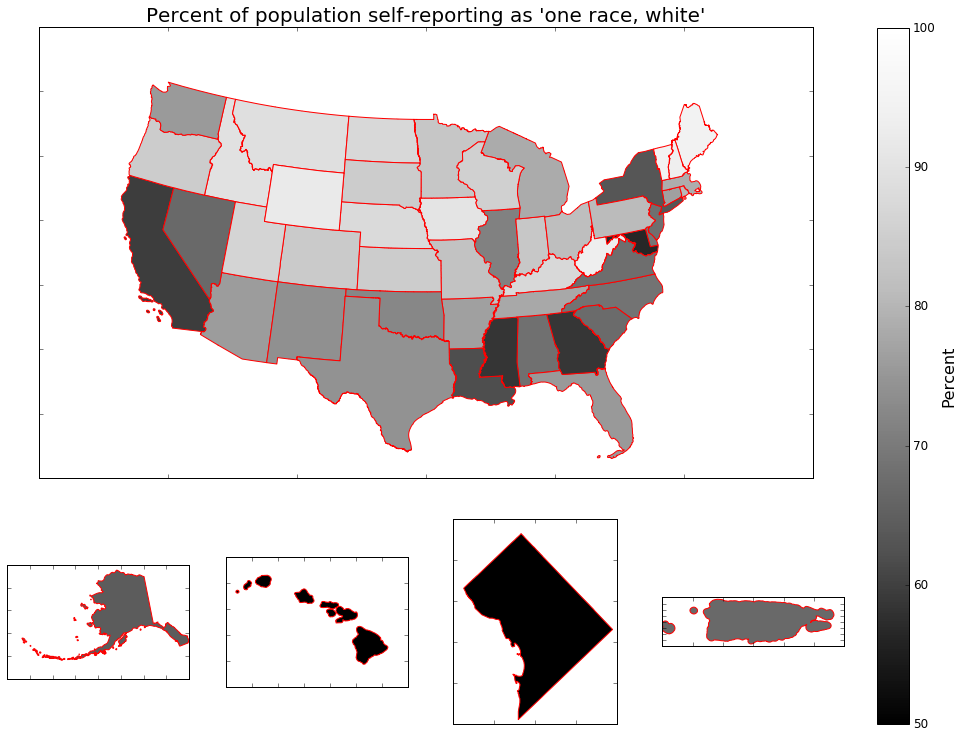

In [9]:
### PLOT MAPPABLY
import matplotlib.gridspec as gridspec

# Plot figure with subplots of different sizes
fig = plt.figure(1, figsize=(15, 12.5))

# set up subplot grid
gridspec.GridSpec(3,4)

# large subplot
ax1 = plt.subplot2grid((3,4), (0,0), colspan=4, rowspan=2)

ax1 = lower48_gdf.plot(ax=ax1, column='percent_white', cmap='Greys_r', edgecolor='red', vmin=50, vmax=100)
ax1.set_title('Percent of population self-reporting as \'one race, white\'', fontsize=20)
ax1.set_aspect('equal')
#ax1.set_xlim(-130, -65)
#ax1.set_ylim(23,50)

# small subplot: #2
ax2 = plt.subplot2grid((3,4), (2,0))
ax2 = ak_gdf.plot(ax=ax2, column='percent_white', cmap='Greys_r', edgecolor='red', vmin=50, vmax=100)
ax2.set_aspect('equal')
#ax2.set_xlim(-180, -130)
#ax2.set_ylim(45,75)

# small subplot: #3
ax3 = plt.subplot2grid((3,4), (2,1))
ax3 = hi_gdf.plot(ax=ax3, column='percent_white', cmap='Greys_r', edgecolor='red', vmin=50, vmax=100)
ax3.set_aspect('equal')
ax3.set_xlim(-161, -154)
ax3.set_ylim(18,23)

# small subplot: #4
ax4 = plt.subplot2grid((3,4), (2,2))
ax4 = dc_gdf.plot(ax=ax4, column='percent_white', cmap='Greys_r', edgecolor='red', vmin=50, vmax=100)
ax4.set_aspect('equal')

# small subplot: #5
ax4 = plt.subplot2grid((3,4), (2,3))
ax4 = pr_gdf.plot(ax=ax4, column='percent_white', cmap='Greys_r', edgecolor='red', vmin=50, vmax=100)
ax4.set_aspect('equal')

for ax in fig.get_axes():
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
#        bottom='off',      # ticks along the bottom edge are off
#        top='off',         # ticks along the top edge are off
#        left='off',
#        right='off',
        labelleft='off',
        labelbottom='off') # labels along the bottom edge are off

# fit subplots and save fig
#fig.tight_layout()
#fig.set_size_inches(w=11,h=7)
#fig_name = 'plot.png'
#fig.savefig(fig_name)

# add colorbar
cax = fig.add_axes([0.93, 0.125, 0.03, 0.774])
sm = plt.cm.ScalarMappable(cmap='Greys_r', norm=plt.Normalize(vmin=50, vmax=100))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cbar = fig.colorbar(sm, cax=cax, format='%.0f', ticks=np.arange(0, 110, 10))
cax.tick_params(labelsize=12)
cbar.set_label('Percent', fontsize=16)

plt.show()

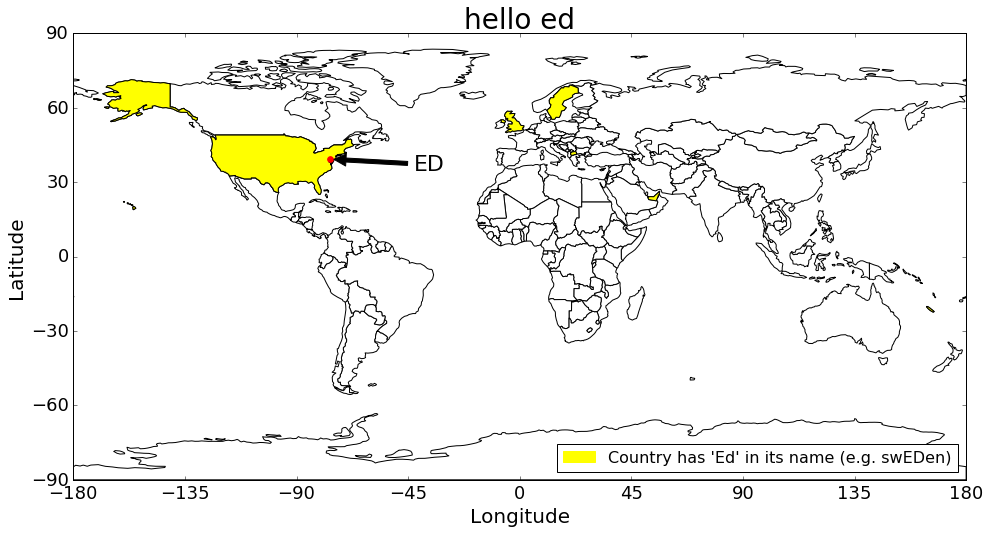

In [14]:
### EXAMPLE: SIMPLE PLOT OF EARTH COUNTRIES
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot()

### EXAMPLE: PLOT ALL COUNTRIES THAT EXTEND INTO THE SOUTHERN HEMPISPHERE
#southern_world = world.cx[:, :0]
#southern_world.plot(figsize=(10, 3))
#plt.show()


### EXAMPLE: OVERLAY CITIES ON WORLD MAP
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
#cities = cities.to_crs(world.crs)
#base = world.plot(color='white', edgecolor='black', figsize=(12,12))
#cities.plot(ax=base, marker='o', color='red', markersize=5, figsize=(12,12))
#plt.show()

### EXAMPLE: COLOR-CODE COUNTRIES BY PER CAPITA GDP
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world = world[(world.pop_est>0) & (world.name!="Antarctica")]
#world['gdp_per_cap'] = world.gdp_md_est / world.pop_est
#world.plot(column='gdp_per_cap', figsize=(12,12), cmap='OrRd')
#plt.show()


### EXAMPLE: HELLO ED
import numpy as np
import string
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.set_index('iso_a3')

world['ed'] = np.where(world['name'].apply(lambda x: 'ed' in x.lower()),1,0)
world['ed']
raw_data = [("Ed", 39.299236, -76.609383)]

edplace = pandas.DataFrame(raw_data, columns=["name", "latitude", "longitude"])
edplace['geometry'] = [Point(xy) for xy in zip(edplace.longitude, edplace.latitude)]

thecrs = {'init': 'epsg:4326'}
edplacer = gpd.GeoDataFrame(edplace, crs=thecrs, geometry="geometry")
edplacer = edplacer.to_crs(world.crs)

fig, ax = plt.subplots(figsize=(16,10))
ax.set_aspect('equal')
ax1 = world.plot(ax=ax, color='white', edgecolor='black')
ax2 = world[world['ed'] == 1].plot(ax=ax, color='yellow')
ax3 = edplacer.plot(ax=ax, marker='o', color='red', markersize=32)
ax.annotate('ED', xy=(-76.609383, 39.299236), xytext=(-42.5, 35),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=22
            )
plt.xlim(-180, 180)
plt.ylim(-90,90)
plt.title('hello ed', fontsize=28)

plt.xticks(np.arange(-180, 180.01, 45), fontsize=18)
plt.xlabel('Longitude', fontsize=20)
plt.yticks(np.arange(-90, 90.01, 30), fontsize=18)
plt.ylabel('Latitude', fontsize=20)
yellow_patch = mpatches.Patch(color='yellow', label="Country has 'Ed' in its name (e.g. swEDen)")
plt.legend(handles=[yellow_patch], loc='lower right', fontsize=16)

plt.show()
#print('ok')
#sumlevel_df

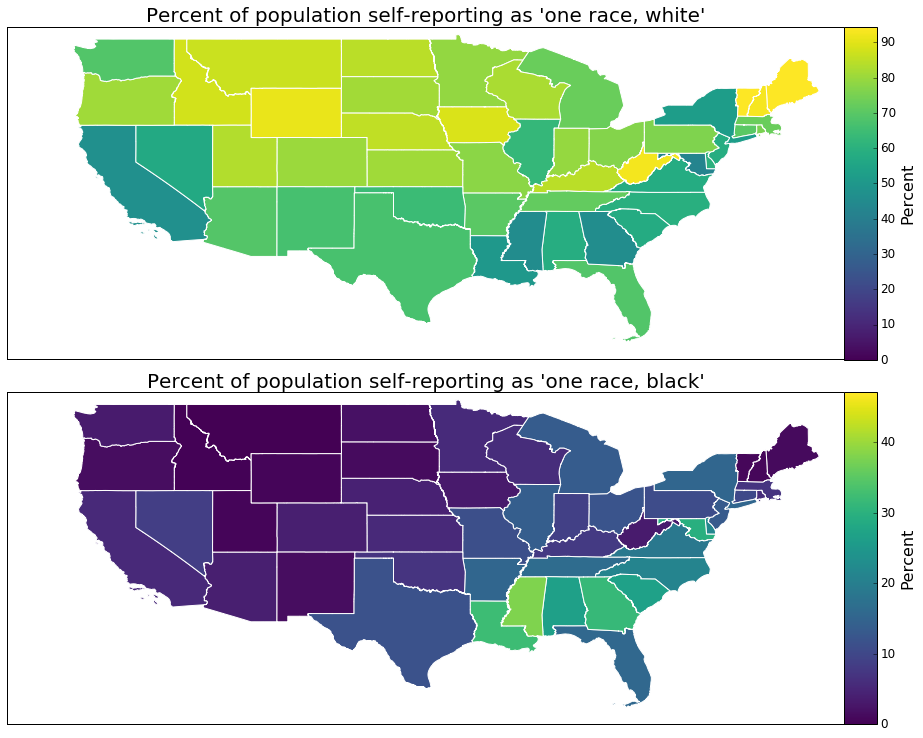

In [15]:
#### DISPLAY BLACK AND WHITE ON TWO SEPARATE MAPS; ALSO SET COORD LIMITS MANUALLY

fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, figsize=(15,12.5))

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.subplots_adjust(hspace=0.1)

#plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)

ax1 = ourdata_gdf.plot(ax=ax1, column='percent_white', cmap='viridis', edgecolor='white')
ax1.set_title('Percent of population self-reporting as \'one race, white\'', fontsize=20)

ax2 = ourdata_gdf.plot(ax=ax2, column='percent_black', cmap='viridis', edgecolor='white')
ax2.set_title('Percent of population self-reporting as \'one race, black\'', fontsize=20)

ax1.set_xlim(-130, -65)
ax1.set_ylim(23,50)

ax2.set_xlim(-130, -65)
ax2.set_ylim(23,50)

ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    left='off',
    right='off',
    labelleft='off',
    labelbottom='off') # labels along the bottom edge are off

ax2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    left='off',
    right='off',
    labelleft='off',
    labelbottom='off') # labels along the bottom edge are off


# add colorbar
cax1 = fig.add_axes([0.9, 0.53, 0.03, 0.37])
sm1 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=maxval1))

# fake up the array of the scalar mappable. Urgh...
sm1._A = []

cbar1 = fig.colorbar(sm1, cax=cax1, format='%.0f', ticks=np.arange(0, 100, 10))

cax1.tick_params(labelsize=12)
cbar1.set_label('Percent', fontsize=16)

# add colorbar
cax2 = fig.add_axes([0.9, 0.125, 0.03, 0.36875])
sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=maxval2))

# fake up the array of the scalar mappable. Urgh...
sm2._A = []

cbar2 = fig.colorbar(sm2, cax=cax2, format='%.0f', ticks=np.arange(0, 50, 10))

cax2.tick_params(labelsize=12)
cbar2.set_label('Percent', fontsize=16)


plt.show()
#print('ok')
#gdf = GeoDataFrame(df, crs=crs, geometry=geometry)
#type(ourdata_gdf)

In [ ]:
#### CARTOPY EXAMPLES


import cartopy.crs as ccrs
import matplotlib.pyplot as plt

#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.coastlines()

#plt.show()

#ax = plt.axes(projection=ccrs.Mollweide())
#ax.stock_img()
#ax.coastlines()
#plt.show()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()

ny_lon, ny_lat = -75, 43
delhi_lon, delhi_lat = 77.23, 28.61

plt.plot([ny_lon, delhi_lon], [ny_lat, delhi_lat],
         color='blue', linewidth=2, marker='o',
         transform=ccrs.Geodetic(),
         )

plt.plot([ny_lon, delhi_lon], [ny_lat, delhi_lat],
         color='gray', linestyle='--',
         transform=ccrs.PlateCarree(),
         )

plt.text(ny_lon - 3, ny_lat - 12, 'New York',
         horizontalalignment='right',
         transform=ccrs.Geodetic())

plt.text(delhi_lon + 3, delhi_lat - 12, 'Delhi',
         horizontalalignment='left',
         transform=ccrs.Geodetic())

plt.show()

In [17]:
#POPULATION BY CENSUS REGION
data_df['SUMLEVEL'] = data_df['GEOID'].apply(lambda x: int(x[0:3]))

print('Estimated U.S. population: {0:,.0f}'.format(data_df['B01001_001'].loc['01000US']))

print('For the four census regions: {0:,.0f}'.format(data_df['B01001_001'][data_df['GEOID'].apply(lambda x: x[0:7]) == '02000US'].sum()))
print('\n')
print('Population by census region:')
print('{0:} {1:,.0f}'.format(data_df['NAME'].loc['02000US1'], data_df['B01001_001'].loc['02000US1']))
print('{0:} {1:,.0f}'.format(data_df['NAME'].loc['02000US2'], data_df['B01001_001'].loc['02000US2']))
print('{0:} {1:,.0f}'.format(data_df['NAME'].loc['02000US3'], data_df['B01001_001'].loc['02000US3']))
print('{0:} {1:,.0f}'.format(data_df['NAME'].loc['02000US4'], data_df['B01001_001'].loc['02000US4']))

#print('Men: {0:,.0f} (error: {1:,.0f})'.format(data_df['B01001_002'].loc['01000US'], error_df['B01001_002'].loc['01000US']))
#print('Women: {0:,.0f} (error: {1:,.0f})'.format(data_df['B01001_026'].loc['01000US'], error_df['B01001_026'].loc['01000US']))

#print('Margin of error: {0:,.0f}'.format(error_df['B01001_001'].loc['01000US']))

Estimated U.S. population: 323,127,515
For the four census regions: 323,127,515


Population by census region:
Northeast Region 56,209,510
Midwest Region 67,941,431
South Region 122,319,574
West Region 76,657,000


In [19]:
# POPULATION BY STATE
data_df[data_df['SUMLEVEL'] == 40]

display(HTML('<h2>Population by state</h2>'))

statetable = '<table><tr><th>State</th><th>Population</th></tr>'
for thisgeoid, thisrow in data_df[data_df['GEOID'].apply(lambda x: x[0:5]) == '04000'].iterrows():
    statetable += '<tr>'
    statetable += '<td>{0:}</td><td style="text-align:right;padding:5px">{1:,.0f}</td>'.format(thisrow['NAME'], thisrow['B01001_001'])
    statetable += '</tr>'
statetable += '</table>'

display(HTML(statetable))

total_population = data_df['B01001_001'][data_df['GEOID'].apply(lambda x: x[0:5]) == '04000'].sum()

display(HTML(('TOTAL of all 50 states: <b>{0:,.0f}</b> (not equal to national b/c military etc. is federal)'.format(total_population))))
#print('For the four census regions: {0:,.0f}'.format(data_df['B01001_001'][data_df['GEOID'].apply(lambda x: x[0:7]) == '02000US'].sum()))
#data_df['B01001_001'][data_df['GEOID'].apply(lambda x: x[0:7]) == '02000US']

State,Population
Alaska,"741,894"
Alabama,"4,863,300"
Arkansas,"2,988,248"
Arizona,"6,931,071"
California,"39,250,017"
Colorado,"5,540,545"
Connecticut,"3,576,452"
District of Columbia,"681,170"
Delaware,"952,065"
Florida,"20,612,439"
